In [1]:
#import dependencies 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2 as cv
import random
from PIL import Image, ImageDraw
#from keras.preprocessing import image
from PIL import ImagePath 
import imageio
import matplotlib as mpl
import matplotlib.image as mpimg
import scipy.ndimage as ndi
from basic_image_eda import BasicImageEDA
import imageio
from skimage import exposure
from scipy import ndimage as ndi
#from tensorflow.keras.applications import VGG16


In [2]:
!pip install autogluon.vision

  Using cached autogluon.vision-0.0.16b20210206-py3-none-any.whl (18 kB)
  Using cached Pillow-6.2.1.tar.gz (37.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached gluoncv-0.10.5.post0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached d8-0.0.2.post0-py3-none-any.whl (28 kB)
  Using cached autogluon.core-0.0.16b20210206-py3-none-any.whl (297 kB)
  Using cached autogluon.mxnet-0.0.16b20210206-py3-none-any.whl (31 kB)
  Using cached openml-0.14.2.tar.gz (144 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scipy-1.4.1.tar.gz (24.6 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3795 lines of output]
      Ignoring nu

**Investigating a single image from the dataset**

In [2]:
#investigate a single image from positive dataset
pos_path = '/dataset/train/POSITIVE/'
def load_image(path):
    for img in os.listdir(pos_path):
        print('Image name =', img)
        image = cv.imread(os.path.join(pos_path, img))
        break

    return image

Image name = Positive_163_Coronary_221_LAD_Secondary2_18.png
The dimensions are 299 pixels height and 299 pixels width
The maximum pixel value is 163.0000
The minimum pixel value is 0.0000
The mean value of the pixels is 62.3081
The standard deviation is 43.2523


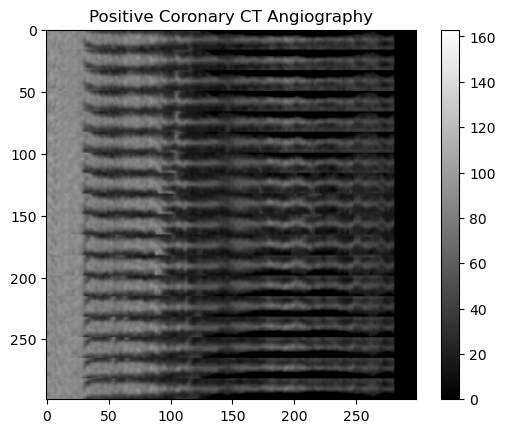

In [3]:
pos_path = './dataset/train/POSITIVE/'

image = load_image(pos_path)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Positive Coronary CT Angiography')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
print(f"The mean value of the pixels is {image.mean():.4f}")
print(f"The standard deviation is {image.std():.4f}")


In [4]:
#investigate a single image from negative dataset
neg_path = '/dataset/train/NEGATIVE/'
def load_image(path):
    for img in os.listdir(neg_path):
        print('Image name =', img)
        image = cv.imread(os.path.join(neg_path, img))
        break

    return image

Image name = Negative_105_Coronary_015_RCA_Secondary2_1.png
The dimensions are 299 pixels height and 299 pixels width
The maximum pixel value is 104.0000
The minimum pixel value is 0.0000
The mean value of the pixels is 36.9210
The standard deviation is 35.8445


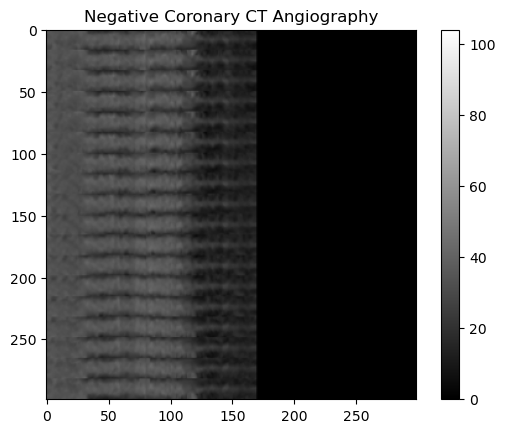

In [5]:
neg_path = './dataset/train/NEGATIVE/'

image = load_image(neg_path)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Negative Coronary CT Angiography')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
print(f"The mean value of the pixels is {image.mean():.4f}")
print(f"The standard deviation is {image.std():.4f}")


**Investigating multiple images from the dataset**

In [6]:
train_dir = 'dataset/train/'
pos_imgs = [fn for fn in os.listdir(f'{train_dir}/POSITIVE') if fn.endswith('.png')]
neg_imgs = [fn for fn in os.listdir(f'{train_dir}/NEGATIVE') if fn.endswith('.png')]

In [7]:
select_pos = np.random.choice(pos_imgs, 3, replace = False)
select_neg = np.random.choice(neg_imgs, 3, replace = False)

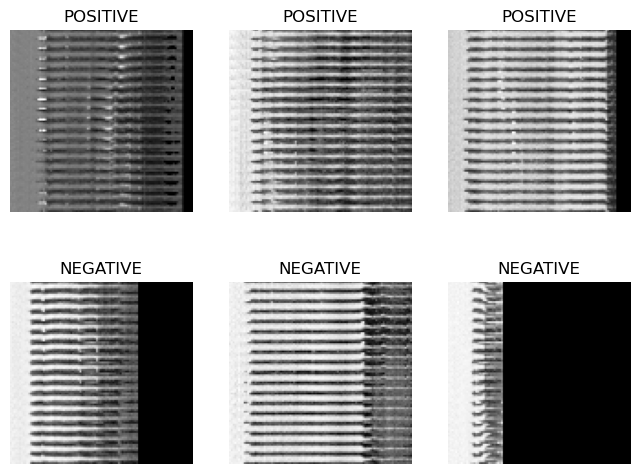

In [8]:
# plotting 2 x 3 image matrix
from keras.preprocessing import image
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/POSITIVE/{select_pos[i]}'
        label = 'POSITIVE'
    else:
        fp = f'{train_dir}/NEGATIVE/{select_neg[i-3]}'
        label = 'NEGATIVE'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')

**Loading images and labels together, resizing them & creating dataframe**

In [9]:
#load the path of the train images
#path = 'dataset/train/'
#train = os.listdir(path)

In [10]:
#there are two folders in the train dataset, positive and negative
folders=[]
folders=[f for f in sorted(os.listdir(train_dir)) if not f.startswith('.')]
print(folders)

['Negative', 'Positive']


In [11]:
labels = folders
print (f'The labels are {labels}') 

#setting the size of images we want
image_size = 100
print(f'All images to be resized into {image_size}x{image_size} pixels')

The labels are ['Negative', 'Positive']
All images to be resized into 100x100 pixels


In [12]:
# Get a list of subdirectories (labels)
labels = [label for label in os.listdir(train_dir) if not label.startswith('.')]

# Function to load images and labels
def load_train(train_dir, labels):
    images = []
    label_enum = 0
    image_names = []
    label_list = []
    
    # Iterate over each label
    for label in labels:
        # Get the path to the label directory
        label_dir = os.path.join(train_dir, label)
        
        # Iterate over each image in the label directory
        for image_name in os.listdir(label_dir):
            # Read and resize the image
            image_path = os.path.join(label_dir, image_name)
            image_read = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read, (image_size, image_size))
            
            # Append the resized image to the images list
            images.append(image_resized)
            
            # Append the label enum to the label_list
            label_list.append(label_enum)
            
            # Append the image name to the image_names list
            image_names.append(image_name)
        
        # Increment the label enum for the next label
        label_enum += 1
    
    # Convert lists to numpy arrays
    images = np.array(images)
    label_list = np.array(label_list)
    
    return images, label_list, image_names


In [13]:
# Load images, labels, and image names
train_images, train_labels, image_names = load_train(train_dir, labels)
print(f'Shape of the training images = {train_images.shape}')
print(f'Shape of the training labels = {train_labels.shape}')

Shape of the training images = (4668, 100, 100)
Shape of the training labels = (4668,)


In [14]:
# Create a DataFrame with image filenames and their labels
train_df = pd.DataFrame({'Image Name': image_names, 'Label': train_labels})

# Map label numbers to label names
train_df['Label'] = train_df['Label'].map({i: label for i, label in enumerate(labels)})


In [15]:
# Display the DataFrame
train_df

Image Name     Label
0     Positive_163_Coronary_221_LAD_Secondary2_18.png  Positive
1               Positive_109_Coronary_706_RCA1_13.png  Positive
2      Positive_171_Coronary_470_LAD_Secondary1_9.png  Positive
3               Positive_202_Coronary_073_RCA1_13.png  Positive
4                Positive_236_Coronary_466_LAD1_6.png  Positive
...                                               ...       ...
4663   Negative_126_Coronary_408_RCA_Secondary2_1.png  Negative
4664   Negative_130_Coronary_192_RCA_Secondary1_4.png  Negative
4665  Negative_205_Coronary_377_LAD_Secondary7_13.png  Negative
4666   Negative_132_Coronary_197_RCA_Secondary7_7.png  Negative
4667   Negative_185_Coronary_053_LAD_Secondary6_4.png  Negative

[4668 rows x 2 columns]

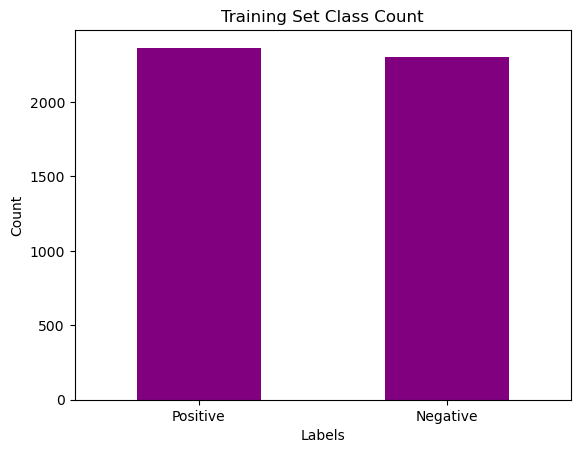

Number of Positive images: 2364
Number of Negative images: 2304


In [51]:
# Plotting the count of each label
label_counts = train_df['Label'].value_counts()
label_counts.plot(kind='bar', color='purple')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Training Set Class Count')
plt.xticks(rotation=0)
plt.show()

for label, count in label_counts.items():
    print(f'Number of {label} images: {count}')

In [50]:
# Define the path to the train folder
train_folder = 'dataset/train/Positive'

# Initialize variables to store statistics
heights = []
widths = []

# Iterate through the images in the train folder
for filename in os.listdir(train_folder):
    # Read the image
    image_path = os.path.join(train_folder, filename)
    img = cv.imread(image_path)
    if img is None:
        continue  # Skip if the file is not an image
    
    # Get the height and width of the image
    height, width, _ = img.shape
    heights.append(height)
    widths.append(width)

# Convert lists to numpy arrays
heights_arr = np.array(heights)
widths_arr = np.array(widths)

# Calculate statistics
count = len(heights_arr)
mean_height = np.mean(heights_arr)
mean_width = np.mean(widths_arr)
std_height = np.std(heights_arr)
std_width = np.std(widths_arr)
min_height = np.min(heights_arr)
min_width = np.min(widths_arr)
max_height = np.max(heights_arr)
max_width = np.max(widths_arr)
percentiles_height = np.percentile(heights_arr, [25, 50, 75])
percentiles_width = np.percentile(widths_arr, [25, 50, 75])

# Print the statistics
print("Count:", count)
print("Height - Mean:", mean_height, "Std:", std_height, "Min:", min_height, "25%:", percentiles_height[0], "50%:", percentiles_height[1], "75%:", percentiles_height[2], "Max:", max_height)
print("Width  - Mean:", mean_width, "Std:", std_width, "Min:", min_width, "25%:", percentiles_width[0], "50%:", percentiles_width[1], "75%:", percentiles_width[2], "Max:", max_width)


Count: 2364
Height - Mean: 299.0 Std: 0.0 Min: 299 25%: 299.0 50%: 299.0 75%: 299.0 Max: 299
Width  - Mean: 299.0 Std: 0.0 Min: 299 25%: 299.0 50%: 299.0 75%: 299.0 Max: 299


**Visualization of images**

**POSITIVE for coronary artery disease**

(299, 299, 3)
[[11 11 11 ...  0  0  0]
 [10 11 11 ...  0  0  0]
 [10 11 11 ...  0  0  0]
 ...
 [11 11 11 ...  0  0  0]
 [11 11 11 ...  0  0  0]
 [11 11 11 ...  0  0  0]]


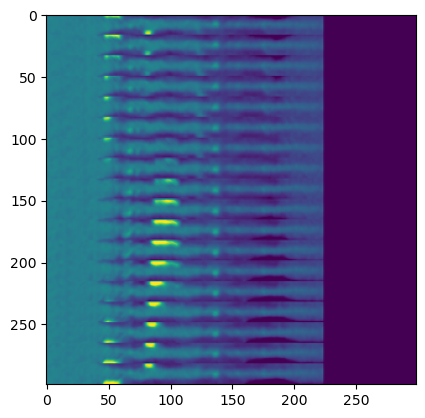

In [17]:
img = Image.new('RGB', (28,28))
img_pos = ImageDraw.Draw(img)
img = cv.imread('dataset/train/POSITIVE/Positive_255_Coronary_073_LAD_Secondary2_16.png')
img = np.array(img)

plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])

**NEGATIVE for coronary artery disease**

(299, 299, 3)
[[7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 ...
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]]


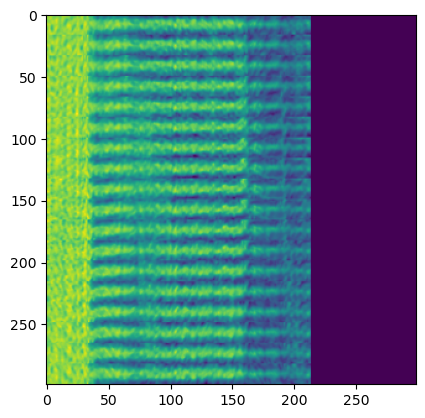

In [18]:
img = Image.new('RGB', (28,28))
img_neg = ImageDraw.Draw(img)
img = cv.imread('dataset/train/NEGATIVE/Negative_92_Coronary_411_RCA_Secondary1_16.png')
img = np.array(img)

plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])

In [19]:
train_df.to_csv('train.csv', index=False)

**HISTOGRAM**

**POSITIVE**

In [20]:
def plot_img_hist(pos_path, num_img=6):
    # List all image files in the folder
    img_files = [os.path.join(pos_path, fn) for fn in os.listdir(pos_path) if fn.endswith('.png')]
    
    # Select a random subset of images
    selected_imgs = np.random.choice(img_files, min(num_img, len(img_files)), replace=False)
    
    # Plot images and histograms
    for idx, img_path in enumerate(selected_imgs):
        fig1 = plt.figure(idx, figsize=(10, 10))
        
        # Plot image
        fig1.add_subplot(2, 2, 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
        # Plot histogram
        fig1.add_subplot(2, 2, 2)
        plt.hist(img.ravel(), bins=256, fc='k', ec='k')
        
    plt.tight_layout()
    plt.show()



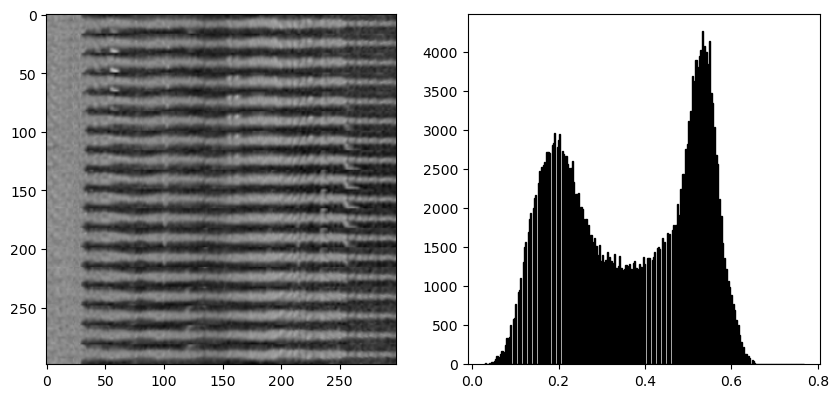

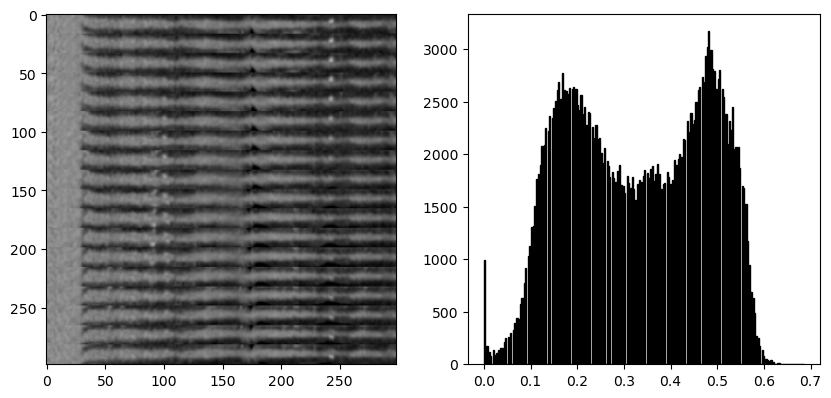

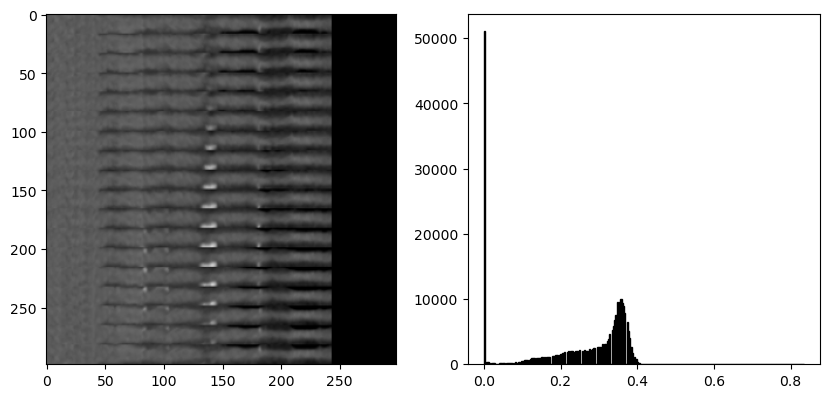

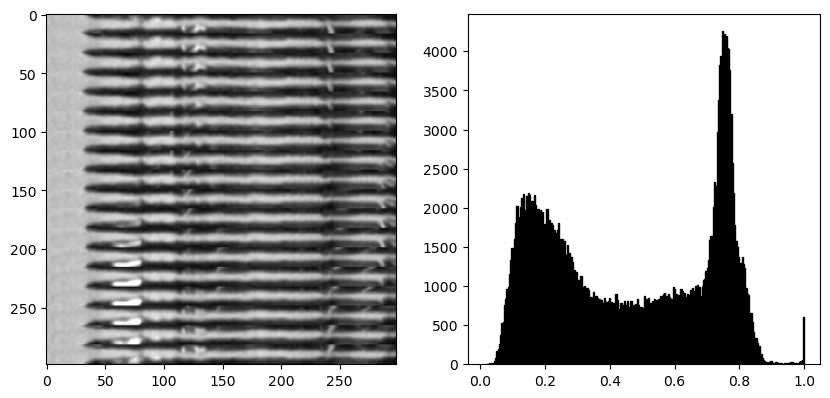

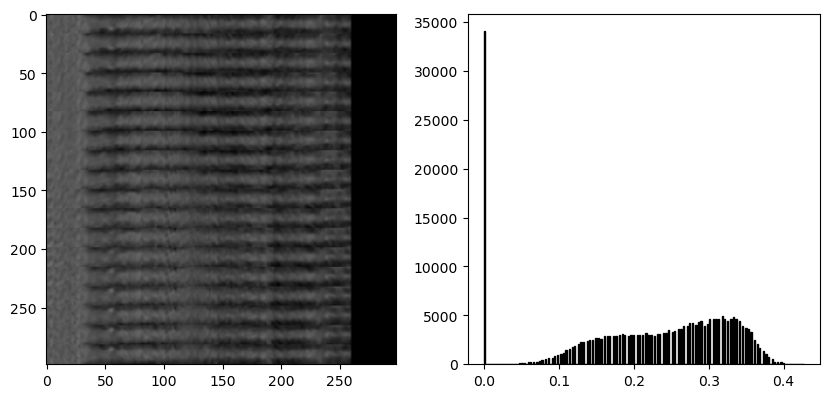

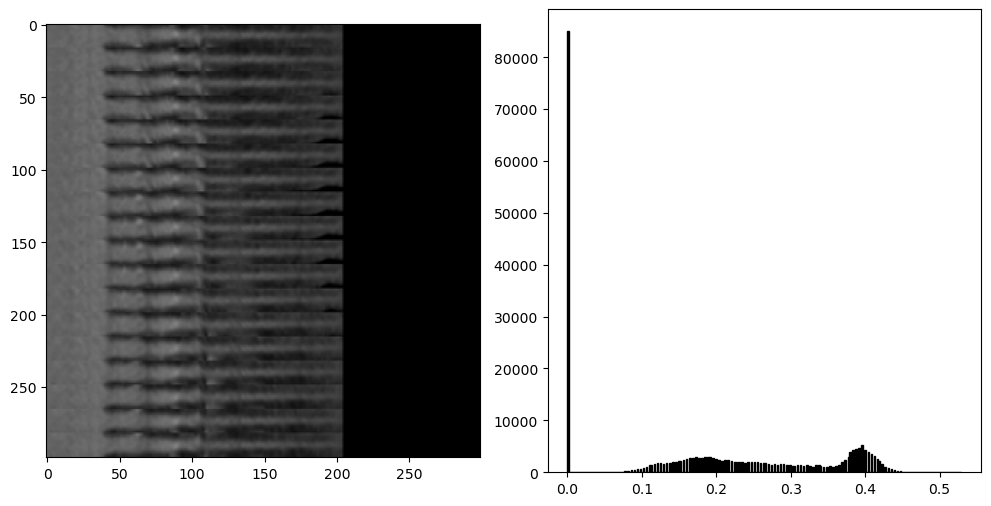

In [21]:
#positive_folder = 'dataset/train/POSITIVE'  # Change this to the path of your positive folder
plot_img_hist(pos_path, num_img=6)

**NEGATIVE**

In [22]:
def plot_img_hist(neg_path, num_img=6):
    # List all image files in the folder
    img_files = [os.path.join(neg_path, fn) for fn in os.listdir(neg_path) if fn.endswith('.png')]
    
    # Select a random subset of images
    selected_imgs = np.random.choice(img_files, min(num_img, len(img_files)), replace=False)
    
    # Plot images and histograms
    for idx, img_path in enumerate(selected_imgs):
        fig1 = plt.figure(idx, figsize=(10, 10))
        
        # Plot image
        fig1.add_subplot(2, 2, 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
        # Plot histogram
        fig1.add_subplot(2, 2, 2)
        plt.hist(img.ravel(), bins=256, fc='k', ec='k')
        
    plt.tight_layout()
    plt.show()



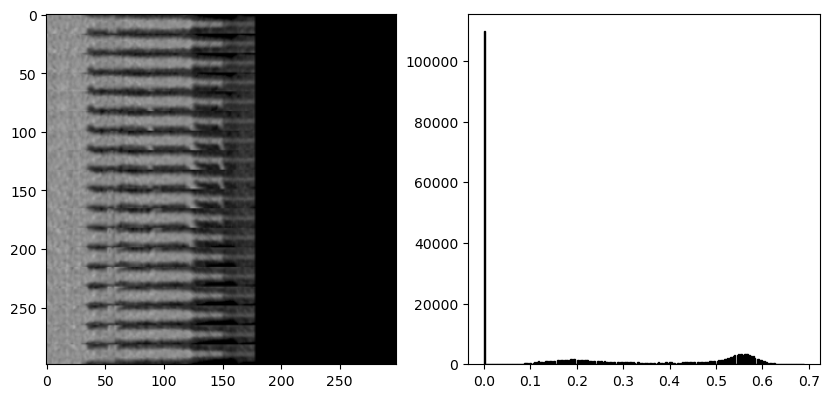

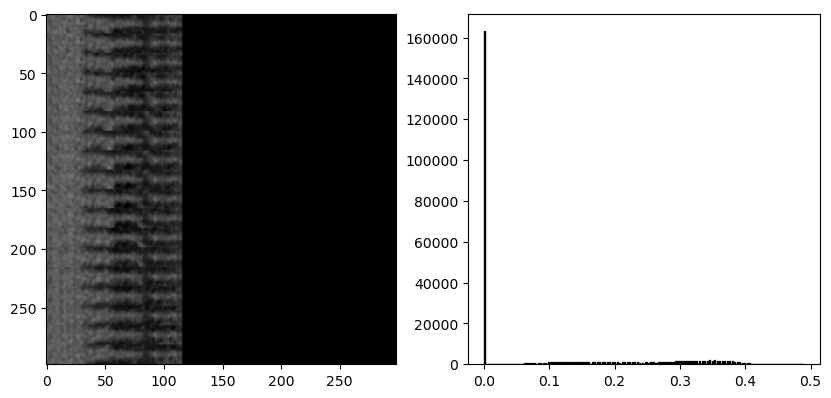

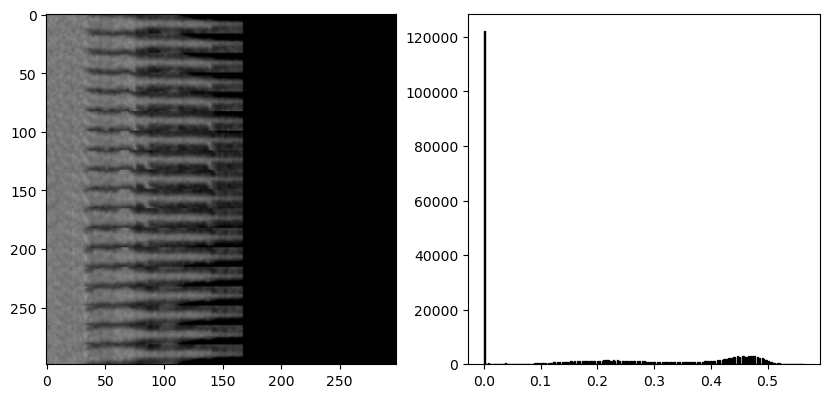

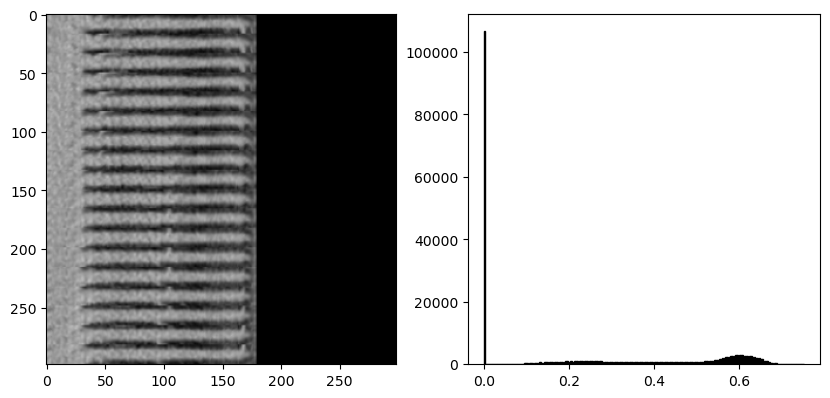

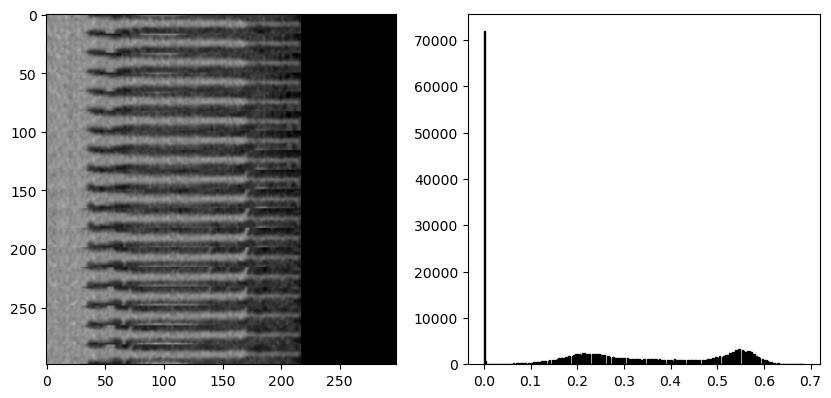

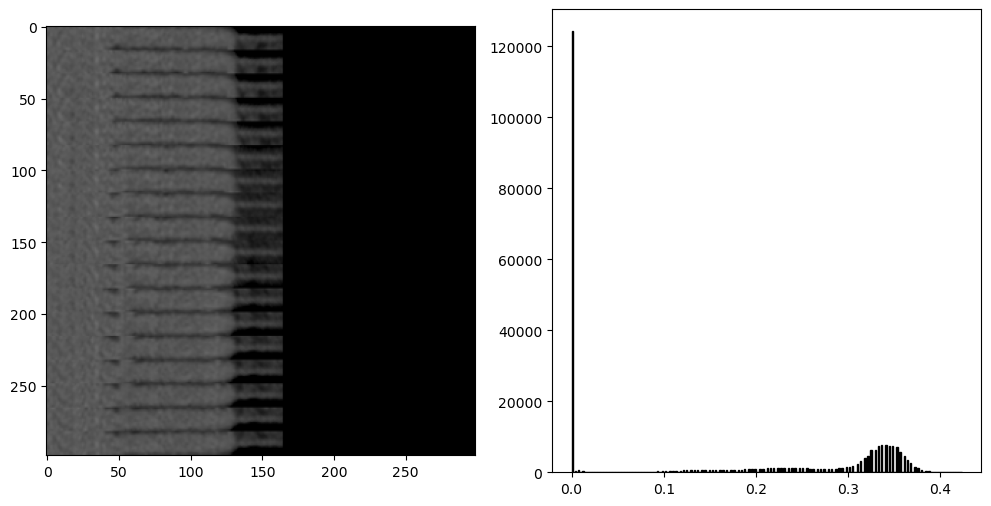

In [23]:
plot_img_hist(neg_path, num_img=6)

**CDF - cumulaion distribution funciton**

**POSITIVE**

In [24]:
def plot_img_hist_ndi(pos_path, num_img=6):
    # List all image files in the folder
    img_files = [os.path.join(pos_path, fn) for fn in os.listdir(pos_path) if fn.endswith('.png')]
    
    # Select a random subset of images
    selected_imgs = np.random.choice(img_files, min(num_img, len(img_files)), replace=False)
    
    # Plot images, histograms, and CDFs
    for idx, img_path in enumerate(selected_imgs):
        im = imageio.imread(img_path)
        hist = ndi.histogram(im, min=0, max=255, bins=256)
        cdf = hist.cumsum() / hist.sum()

        fig1 = plt.figure(idx, figsize=(10, 10))
        
        # Plot image
        fig1.add_subplot(2, 3, 1)
        img = mpimg.imread(img_path)
        plt.title("No. {}".format(idx))
        plt.imshow(img)
        
        # Plot histogram
        fig1.add_subplot(2, 3, 2)
        plt.title("Histogram")
        plt.plot(hist)
        
        # Plot CDF
        fig1.add_subplot(2, 3, 3)
        plt.title("CDF")
        plt.plot(cdf)

    plt.tight_layout()
    plt.show()

/var/folders/zd/py_m16pj5_q900frdknc27f00000gn/T/ipykernel_61230/1400468830.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(img_path)


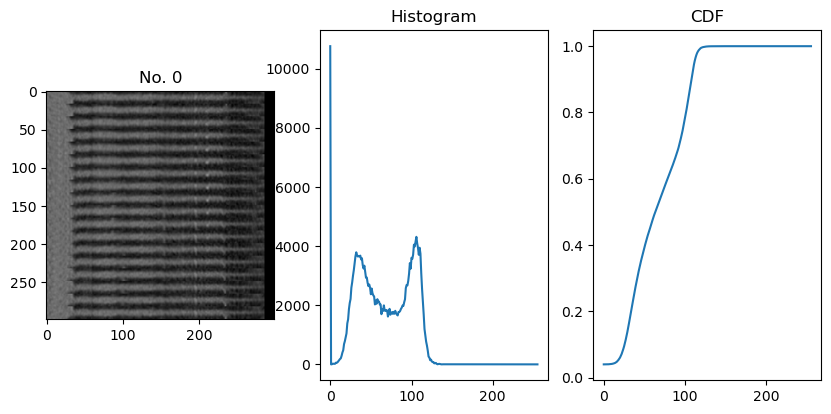

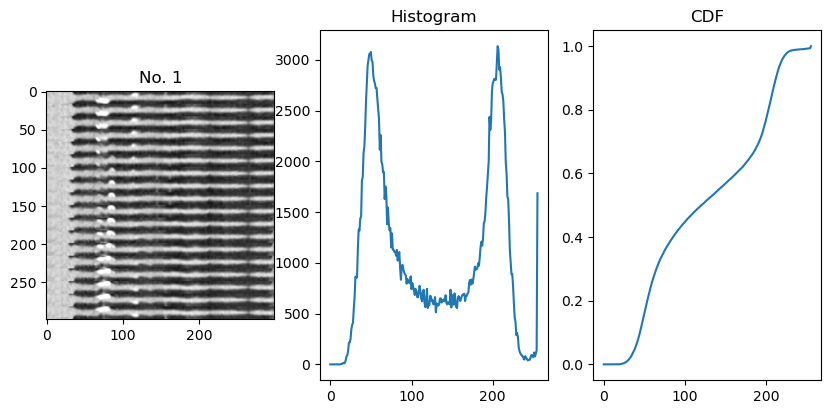

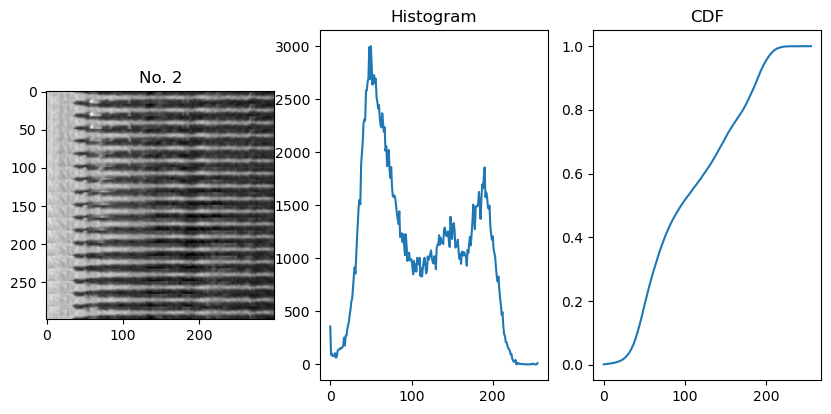

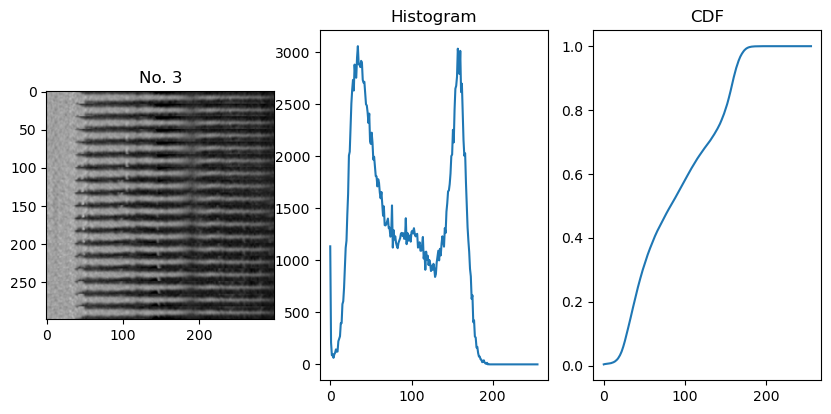

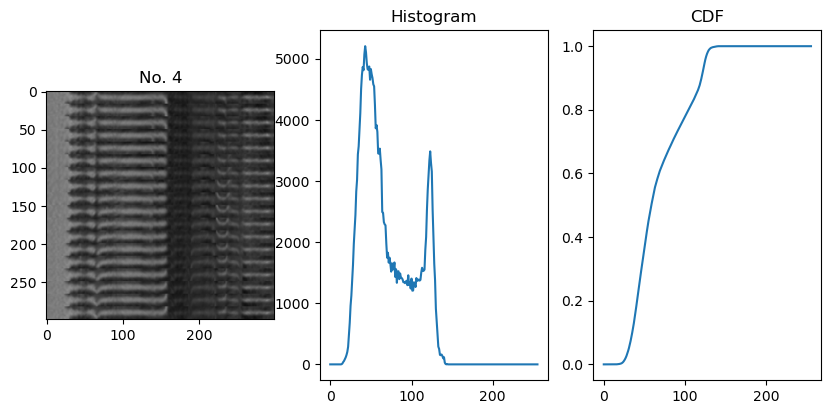

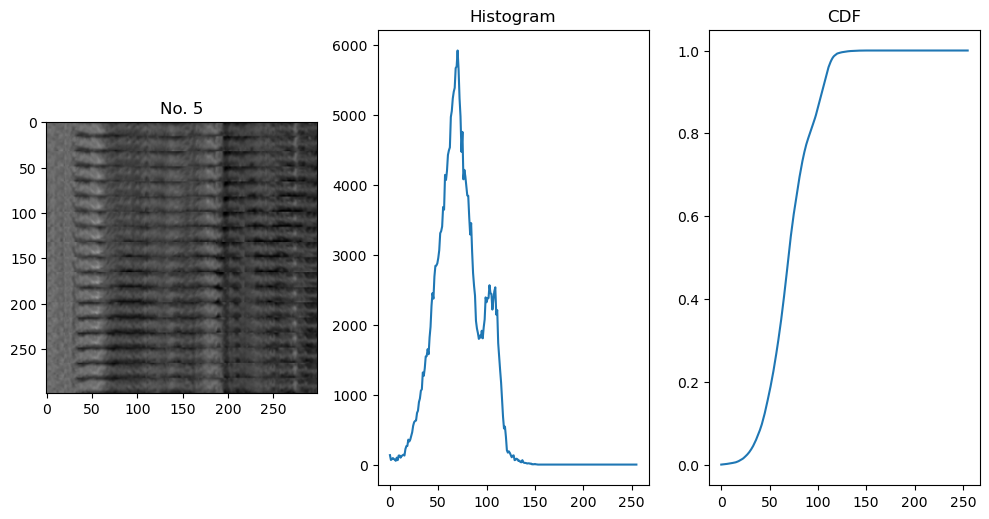

In [25]:
# show 6 images from the positive folder with their histograms and CDFs
plot_img_hist_ndi(pos_path, num_img=6)

**NEGATIVE**

In [26]:
def plot_img_hist_ndi(neg_path, num_img=6):
    # List all image files in the folder
    img_files = [os.path.join(neg_path, fn) for fn in os.listdir(neg_path) if fn.endswith('.png')]
    
    # Select a random subset of images
    selected_imgs = np.random.choice(img_files, min(num_img, len(img_files)), replace=False)
    
    # Plot images, histograms, and CDFs
    for idx, img_path in enumerate(selected_imgs):
        im = imageio.imread(img_path)
        hist = ndi.histogram(im, min=0, max=255, bins=256)
        cdf = hist.cumsum() / hist.sum()

        fig1 = plt.figure(idx, figsize=(10, 10))
        
        # Plot image
        fig1.add_subplot(2, 3, 1)
        img = mpimg.imread(img_path)
        plt.title("No. {}".format(idx))
        plt.imshow(img)
        
        # Plot histogram
        fig1.add_subplot(2, 3, 2)
        plt.title("Histogram")
        plt.plot(hist)
        
        # Plot CDF
        fig1.add_subplot(2, 3, 3)
        plt.title("CDF")
        plt.plot(cdf)

    plt.tight_layout()
    plt.show()

/var/folders/zd/py_m16pj5_q900frdknc27f00000gn/T/ipykernel_61230/1211744662.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(img_path)


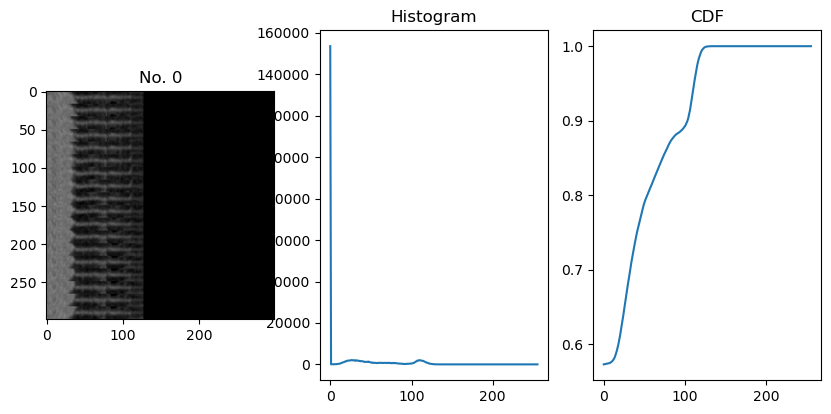

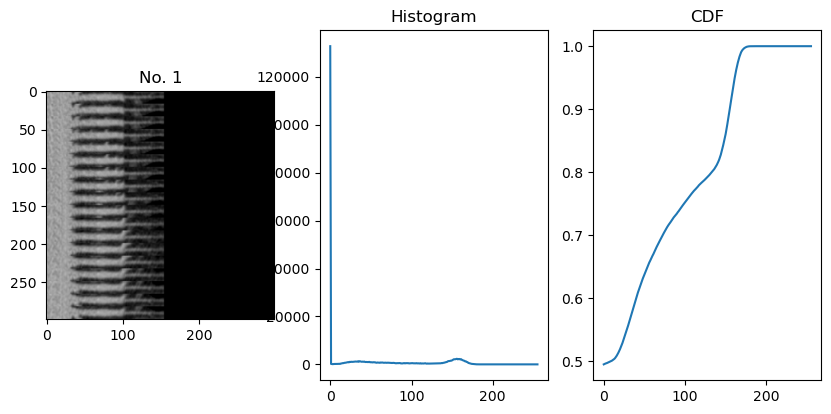

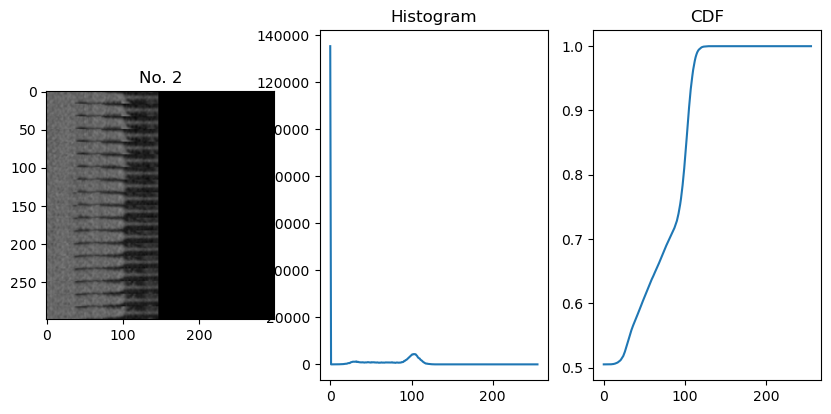

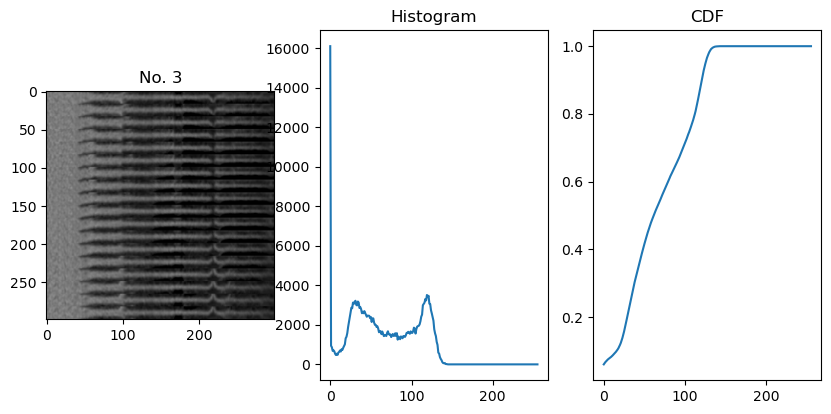

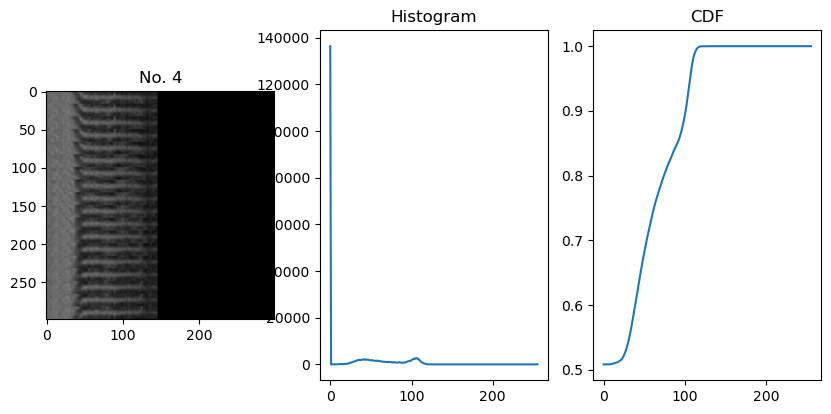

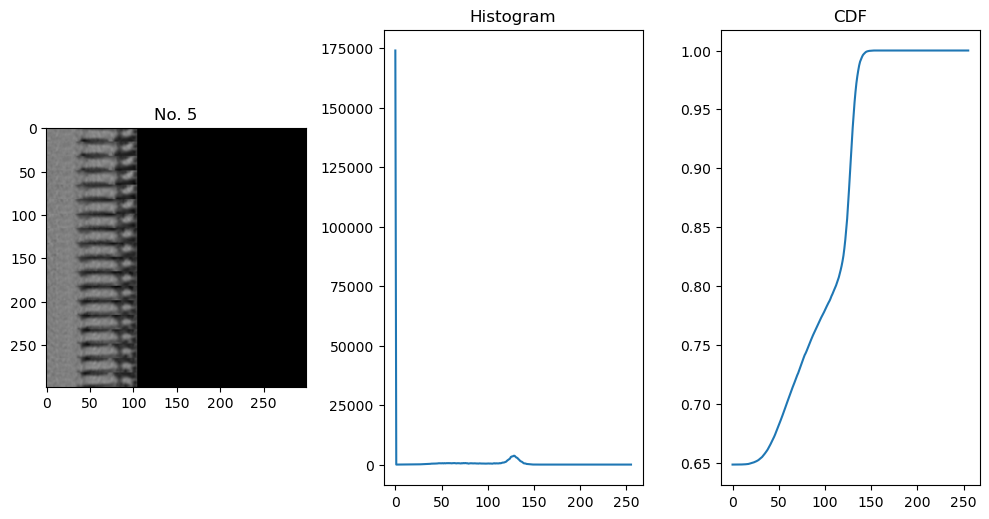

In [27]:
# show 6 images from the negative folder with their histograms and CDFs
plot_img_hist_ndi(neg_path, num_img=6)

**Distribution of classes (POS vs NEG) in Train and Test sets**

In [28]:
test_dir = 'dataset/test/'

In [29]:
# Get a list of subdirectories (labels)
labels = [label for label in os.listdir(test_dir) if not label.startswith('.')]

# Function to load images and labels
def load_test(test_dir, labels):
    images = []
    label_enum = 0
    image_names = []
    label_list = []
    
    # Iterate over each label
    for label in labels:
        # Get the path to the label directory
        label_dir = os.path.join(test_dir, label)
        
        # Iterate over each image in the label directory
        for image_name in os.listdir(label_dir):
            # Read and resize the image
            image_path = os.path.join(label_dir, image_name)
            image_read = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read, (image_size, image_size))
            
            # Append the resized image to the images list
            images.append(image_resized)
            
            # Append the label enum to the label_list
            label_list.append(label_enum)
            
            # Append the image name to the image_names list
            image_names.append(image_name)
        
        # Increment the label enum for the next label
        label_enum += 1
    
    # Convert lists to numpy arrays
    images = np.array(images)
    label_list = np.array(label_list)
    
    return images, label_list, image_names




In [30]:
# Load images, labels, and image names
test_images, test_labels, image_names = load_test(test_dir, labels)
print(f'Shape of the training images = {test_images.shape}')
print(f'Shape of the training labels = {test_labels.shape}')

Shape of the training images = (1191, 100, 100)
Shape of the training labels = (1191,)


In [31]:
# Create a DataFrame with image filenames and their labels
test_df = pd.DataFrame({'Image Name': image_names, 'Label': test_labels})

# Map label numbers to label names
test_df['Label'] = test_df['Label'].map({i: label for i, label in enumerate(labels)})


In [32]:
test_df

Image Name     Label
0               Positive_Coronary_644_LAD1_5.png  Positive
1               Positive_Coronary_708_LAD1_6.png  Positive
2               Positive_Coronary_479_RCA1_2.png  Positive
3               Positive_Coronary_454_RCA1_8.png  Positive
4               Positive_Coronary_228_LAD1_1.png  Positive
...                                          ...       ...
1186   Negative_Coronary_389_CX_Secondary2_1.png  Negative
1187  Negative_Coronary_380_LAD_Secondary4_1.png  Negative
1188   Negative_Coronary_338_CX_Secondary1_1.png  Negative
1189  Negative_Coronary_123_CX_Secondary10_1.png  Negative
1190  Negative_Coronary_319_LAD_Secondary1_1.png  Negative

[1191 rows x 2 columns]

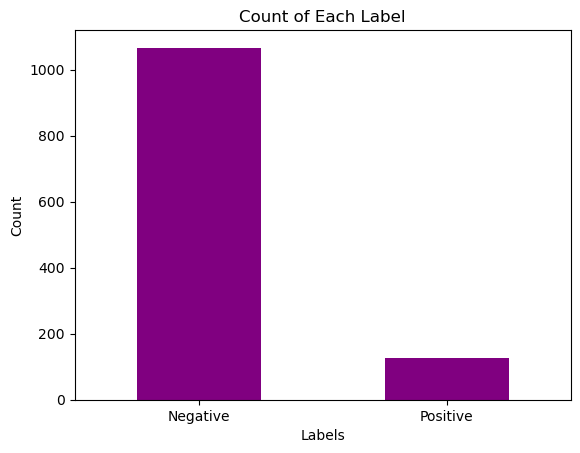

Number of Negative images: 1066
Number of Positive images: 125


In [33]:
# Plotting the count of each label
label_counts = test_df['Label'].value_counts()
label_counts.plot(kind='bar', color='purple')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.xticks(rotation=0)
plt.show()

for label, count in label_counts.items():
    print(f'Number of {label} images: {count}')

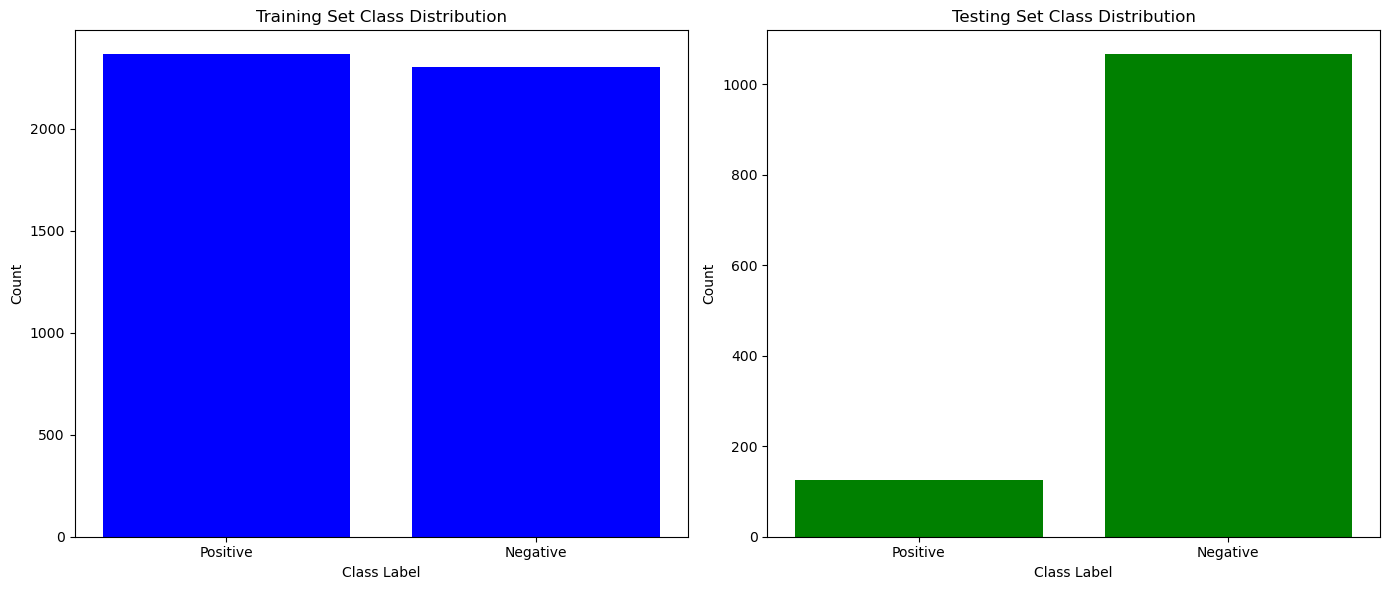

In [34]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames named train_df and test_df containing the training and testing data respectively
# Assuming the 'Label' column contains the class labels (e.g., 'POSITIVE' or 'NEGATIVE')

# Count the occurrences of each class label in the training set
train_class_counts = train_df['Label'].value_counts()

# Count the occurrences of each class label in the testing set
test_class_counts = test_df['Label'].value_counts()

# Plotting the distribution of classes in both the training and testing sets side by side
plt.figure(figsize=(14, 6))

# Plot for training set
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.index, train_class_counts.values, color='blue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')

# Plot for testing set
plt.subplot(1, 2, 2)
plt.bar(['Positive', 'Negative'], test_class_counts.values[::-1], color='green')
plt.title('Testing Set Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
